In [1]:
import numpy as np
from quantities import Hz, ms
from numpy import pi
import imp

from scipy.linalg import eigh, norm
from scipy.special import binom
from scipy.integrate import quad
import scipy.interpolate as interpolate

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import rc
import seaborn as sns

from elephant.spike_train_correlation import corrcoef
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_generation import homogeneous_poisson_process as HPP

## Table of Contents
* [An angle as similiarity measure between matrices](#intro)
* [Building the null hypothesis test](#nullhyp)
    * [the null hypothesis](#)
    * [random (poisson) activity -> random correlation matrix](#)
    * [random correlation matrix -> randomly distributed eigenvectors](#)
    * [the direction ambiquiting of eigenvectors](#)
    * [angle distribution between random vectors in N-dim](#)
    * [distribution of eigenvalues](#)
    * [distribution of weighted angles](#)
    * [distribution of the mean of the weighted angle distribution](#)
* [The eigenangle in action: effects of deviations from the null hypothesis](#)
    * [violation of Poisson assumption](#)
    * [detection of correlated groups](#)

# An angle as similiarity measure between matrices <a id='intro'></a>

Measure of shared non-randomness between matrices of the same basis.

Use to compare network activity in neural networks (given the same or sufficiently equal networks)

We start with the general case building the test based on the eigenvector and value distribution of random matrices and show how to apply this to the comparison of spiking network activity.

# Building the null hypothesis test <a id='nullhyp'></a>


## the null hypthesis

activity of $N$ independet neurons with only chance correlation

## random correlation matrix -> randomly distributed eigenvectors

A correlation matrix is a matrix of pairwise correlation coefficient between every node in a network and can be characterized by its following properties: [propbaly generalizable to hermitian matrices]

* The matrix is symmetric.
* All elements are real and $\in$ [$-1,1$].
* The diagonal elements are $1$.
* The matrix is positive definte, i.e., all eigenvalues are $\ge 0$.

Especially the last point entails that not every set of randomly drawn correlation coefficents can form a correlation matrix. The pairwise correlation are not entirely independent from each other. This interdependence forms the basis of what we refer to as 'correlation structure'. What makes the correlation matrix random is that the correlation coefficients are, within these constraints, randomly sampled. The reason why this is interesting for the characterizaion of network activity, is that the chance correlations between independent point processes form a random correlation matrix.

The very aspect of randomness we are interested in, is that the normalized eigenvectors of the $N\ \times N$ matrix are random. This means that they are uniformly distributed of the $N-$dim unit-sphere [(*Homes, 1991*)](). Thus, in 2D they are uniformly speard around a circle and in 3D around a ball. This is even though the eigenvectors of matrix are pairwise orthogonal.

Let's demonstrate this. 
To generate random vectors, the easiest way is to exploit their property that the vector components are normal distributed [(*Guhr et al., 1998*)]().
As for the random (correlation) matrix, this can be created by calculating the Gram matrix from a set of normalized random vectors $\mathbf{R} = \mathbf{T}\mathbf{T}^*$, where $\mathbf{T}$ is a matrix with rows $T_i$ being noramlized random vectors [(*Homes, 1991*)]().

In [2]:
def generate_random_vectors(dim=3, nbr_of_vectors=1000):
    random_vectors = np.random.normal(size=(nbr_of_vectors, dim))
    for i, v in enumerate(random_vectors):
        random_vectors[i] /= np.linalg.norm(v)
    return random_vectors

def generate_random_eigenvectors(dim=3, min_nbr_of_vectors=2, alpha=1):
    nbr_of_matrices = int(min_nbr_of_vectors)//int(dim)
    eigenvector_array = np.empty((nbr_of_matrices*dim, dim))
    for i in range(nbr_of_matrices):
        random_vectors = np.random.normal(size=(dim, alpha*dim))
        for j, v in enumerate(random_vectors):
            random_vectors[j] /= np.linalg.norm(v)
        random_corr_matrix = np.dot(random_vectors, random_vectors.T)
        eigenvalues, eigenvectors = eigh(random_corr_matrix)
        eigenvector_array[i*dim:i*dim+dim] = eigenvectors
    return eigenvector_array

def generate_HPP_eigenvectors(dim=3, min_nbr_of_vectors=2, rate=10*Hz, 
                              t_start=0*ms, t_stop=10000*ms, binsize=2*ms):
    nbr_of_matrices = int(min_nbr_of_vectors)//int(dim)
    eigenvector_array = np.empty((nbr_of_matrices*dim, dim))
    for i in range(nbr_of_matrices):
        spiketrains = [HPP(rate=rate, t_start=t_start, t_stop=t_stop) for _ in range(dim)]
        bsts = BinnedSpikeTrain(spiketrains, binsize=binsize, t_start=t_start, t_stop=t_stop)
        random_corr_matrix = corrcoef(bsts, binary=True)
        eigenvalues, eigenvectors = eigh(random_corr_matrix)
        eigenvector_array[i*dim:i*dim+dim] = eigenvectors
    return eigenvector_array

For a quick visual check of the distribution the 3D random vectors and eigenvectors, let's display them in 3D space together.

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

nbr_of_vectors = 1000

# Create a sphere
phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
x = np.sin(phi)*np.cos(theta)
y = np.sin(phi)*np.sin(theta)
z = np.cos(phi)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='b', alpha=1., linewidth=0)

# Generate and draw random vectors
rand_vs = generate_random_vectors(dim=3, nbr_of_vectors=nbr_of_vectors)
ax.scatter(rand_vs[:,0],rand_vs[:,1],rand_vs[:,2], color='r', s=20, label='random vectors')

# Generate and draw eigenvectors of random correlation matrices
rand_evs = generate_random_eigenvectors(dim=3, min_nbr_of_vectors=nbr_of_vectors)
print(len(rand_evs))
ax.scatter(rand_evs[:,0],rand_evs[:,1],rand_evs[:,2], color='g', s=20, label='random eigenvectors')

plt.legend()

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1]);

FigureCanvasNbAgg()

999


So far, so good. However, things get a bit more tricky when we start looking at the angles inbetween those vectors. With angle we always refer to the in-plane angle. In two dimensions things are still exactly how we intuitively expect them to be. The probability distribution for the angle between any two random vectors is uniform between $0^{\circ}$ and $90^{\circ}$. 

In [3]:
%matplotlib notebook
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

def plot_angle_distribution(vectors_a, vectors_b, bins=20, ax=None):
    phi = []
    for v, w in zip(vectors_a, vectors_b):
            phi += [np.arccos(np.dot(v, w))]
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    edges = np.linspace(0, np.pi, bins)
    hist, edges = np.histogram(phi, bins=edges, density=True)
    angles = edges[:-1] + np.diff(edges)/2.
    ax.bar(angles, hist, width=.9*np.diff(edges), alpha=0.5)
    ax.set_xlabel('angle')
    ax.set_ylabel('density')
    ax.set_xticks(np.array([0, .25, .5, .75, 1]) * np.pi)
    ax.set_xticklabels(['0', r'$\frac{1}{4}\pi$', r'$\frac{1}{2}\pi$',
                        r'$\frac{3}{4}\pi$', r'$\pi$'])
    return ax


def update_plot(dim):
    vectors_a = generate_random_vectors(dim=int(dim), nbr_of_vectors=10**5)
    vectors_b = generate_random_vectors(dim=int(dim), nbr_of_vectors=10**5)
    
    ax = plt.gca()
    ax = plot_angle_distribution(vectors_a, vectors_b, ax=ax)
    ax.set_title('{}D random angle distribution'.format(2))
    return None

fig, ax = plt.subplots()
interact(update_plot, dim=widgets.FloatSlider(value=2, min=2, max=10, step=1))


<function __main__.update_plot(dim)>

In higher dimension however random vectors tend to become more and more perpendicular, thus the distribution becomes more and more centralized around $90^{\circ}$, i.e., $\pi/2$.

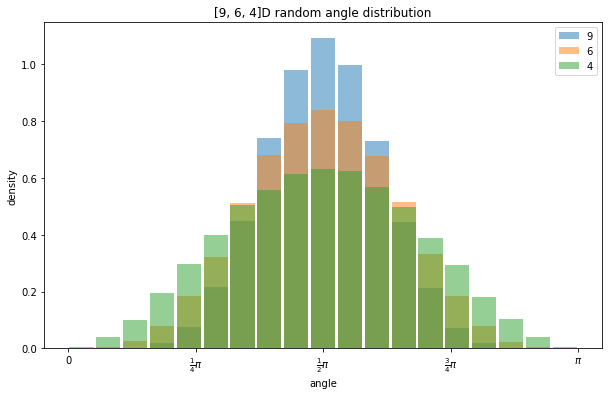

In [7]:
# Todo: Make interactive with slider for the dimension
dims = [9,6,4]
ax = None
for dim in dims:
    vectors_a = generate_random_vectors(dim=dim, nbr_of_vectors=10**5)
    vectors_b = generate_random_vectors(dim=dim, nbr_of_vectors=10**5)
    ax = plot_angle_distribution(vectors_a, vectors_b, ax=ax)
plt.legend(dims)
ax.set_title('{}D random angle distribution'.format(dims));

This distinct shape of the angle distribution as a function of the dimension can be analytically described by a power of sinosoid [(*Cai et al., 2014*)]()
$$ f_\sphericalangle(\phi) \propto \sin^{N-2}\phi \qquad \phi \in [0,\pi]\quad. $$

In [6]:
from math import gamma

angle_dist = lambda phi, dim: gamma(dim/2.) / (np.sqrt(np.pi)*gamma((dim-1)/2)) * np.sin(phi)**(dim-2)

Text(0.5, 1.0, 'analytic distribution of random angles in 6-dim')

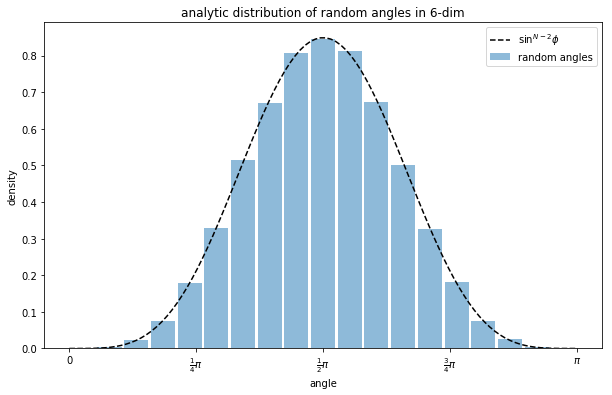

In [7]:
dim = 6
vectors_a = generate_random_vectors(dim=dim, nbr_of_vectors=10**5)
vectors_b = generate_random_vectors(dim=dim, nbr_of_vectors=10**5)
ax = plot_angle_distribution(vectors_a, vectors_b)
phi = np.linspace(0, np.pi, 100)
ax.plot(phi, [angle_dist(p, dim) for p in phi], 'k--')
plt.legend([r'$\sin^{N-2}\phi$', 'random angles'])
ax.set_title('analytic distribution of random angles in {}-dim'.format(dim))

This then of course also describes the angle distribution between the random eigenvectors.

But eigenvectors are more constraint, since the eigenvectors of each matrix are pairwise orthogonal. This causes the distribution to be skewed towards small angles. This effect is especially pronunced for lower dimensions.

Angles between eigenvectors are well described by the distribution of random angles in the case of high dimensionality (dim >~ 10).

Text(0.5, 1.0, 'analytic distribution of random angles in 20-dim')

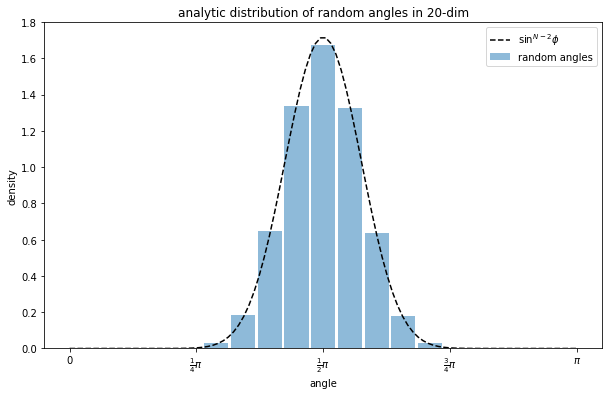

In [11]:
dim = 20
eigenvectors_a = generate_random_eigenvectors(dim=dim, min_nbr_of_vectors=10**5)
eigenvectors_b = generate_random_eigenvectors(dim=dim, min_nbr_of_vectors=10**5)
ax = plot_angle_distribution(eigenvectors_a, eigenvectors_b)
phi = np.linspace(0, np.pi, 100)
ax.plot(phi, [angle_dist(p, dim) for p in phi], 'k--')
plt.legend([r'$\sin^{N-2}\phi$', 'random angles'])
ax.set_title('analytic distribution of random angles in {}-dim'.format(dim))

weighting the angles with the corresponding eigenvalues:

eigenvalue distribution:

In [47]:
def generate_random_eigenvalues(dim=3, min_nbr_of_values=2, alpha=1):
    nbr_of_matrices = int(np.ceil(int(min_nbr_of_values)/int(dim)))       
    eigenvalue_array = np.empty(nbr_of_matrices*dim)
    for i in range(nbr_of_matrices):
        random_vectors = np.random.normal(size=(dim, alpha*dim))
        for j, v in enumerate(random_vectors):
            random_vectors[j] /= np.linalg.norm(v)
        random_corr_matrix = np.dot(random_vectors, random_vectors.T)
        eigenvalues, eigenvectors = eigh(random_corr_matrix)
        eigenvalue_array[i*dim:i*dim+dim] = eigenvalues
        print(random_corr_matrix)
    return eigenvalue_array

def generate_HPP_eigenvalues(dim=3, min_nbr_of_values=2, rate=10*Hz, 
                              t_start=0*ms, t_stop=10000*ms, binsize=2*ms):
    nbr_of_matrices = int(np.ceil(int(min_nbr_of_values)/int(dim)))       
    eigenvalue_array = np.empty(nbr_of_matrices*dim)
    print(nbr_of_matrices)
    for i in range(nbr_of_matrices):
        spiketrains = [HPP(rate=rate, t_start=t_start, t_stop=t_stop) for _ in range(dim)]
        bsts = BinnedSpikeTrain(spiketrains, binsize=binsize, t_start=t_start, t_stop=t_stop)
        random_corr_matrix = corrcoef(bsts, binary=True)
        eigenvalues, eigenvectors = eigh(random_corr_matrix)
        eigenvalue_array[i*dim:i*dim+dim] = eigenvalues
    return eigenvalue_array

1
[[ 1.00000000e+00 -1.20326410e-02  5.55591187e-03 ...  2.25572076e-02
   5.41242453e-03  6.32292585e-03]
 [-1.20326410e-02  1.00000000e+00 -2.50546086e-02 ... -4.23105807e-03
  -2.73877259e-03 -6.60186952e-03]
 [ 5.55591187e-03 -2.50546086e-02  1.00000000e+00 ...  1.49025938e-02
  -2.15926452e-02  7.43931387e-04]
 ...
 [ 2.25572076e-02 -4.23105807e-03  1.49025938e-02 ...  1.00000000e+00
   9.33067531e-03  1.54677339e-02]
 [ 5.41242453e-03 -2.73877259e-03 -2.15926452e-02 ...  9.33067531e-03
   1.00000000e+00  1.41903283e-02]
 [ 6.32292585e-03 -6.60186952e-03  7.43931387e-04 ...  1.54677339e-02
   1.41903283e-02  1.00000000e+00]]


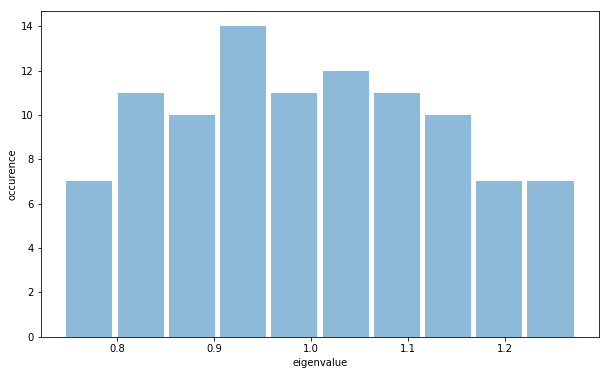

In [48]:
%matplotlib inline
dim = 100
min_nbr_of_values = 10

HPP_ews = generate_HPP_eigenvalues(dim=dim, min_nbr_of_values=min_nbr_of_values)
rand_ews = generate_random_eigenvalues(dim=dim, min_nbr_of_values=min_nbr_of_values)
# print(HPP_ews)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
# edges = np.linspace(0, dim, 100)
hist, edges = np.histogram(rand_ews, density=False)
x = edges[:-1] + np.diff(edges)[0]/2.
ax.bar(x, hist, width=.9*np.diff(edges)[0], alpha=0.5)
ax.set_xlabel('eigenvalue')
ax.set_ylabel('occurence')
plt.show()